In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



2024-07-26 05:18:28.465020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 05:18:28.465168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 05:18:28.592459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

# Load dataset
file_path = "/kaggle/input/ml-data-for-psc-prediction/ML_Data.csv"
data = pd.read_csv(file_path)


# Handle NaN values - fill with mean for numerical and mode for categorical
data.fillna(data.mean(numeric_only=True), inplace=True)
data.fillna(data.mode().iloc[0], inplace=True)

In [4]:

# Selected features
features = ['ETL electron affinity(eV)','Rshunt (ohm cm2)','VOC(V)', 'JSC(mA/cm2)', 'FF(%)']
target = 'PCE(%)'

In [5]:
# Split data into features and target
X = data[features]
y = data[target]

# Identify categorical and numerical features
categorical_features = []
numerical_features = [col for col in features if col not in categorical_features]



In [6]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [7]:
def build_and_compile_model(loss_function):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=[X_train.shape[1], 1]))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=loss_function, 
                  metrics=[MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

model_mae = build_and_compile_model(MeanAbsoluteError())
model_mse = build_and_compile_model(MeanSquaredError())
model_huber = build_and_compile_model(Huber())


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Reshape data for LSTM input
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Train the models
history_mae = model_mae.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2)
history_mse = model_mse.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2)
history_huber = model_huber.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2)



Epoch 1/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.8193 - mean_absolute_error: 1.8193 - rmse: 2.6778 - val_loss: 0.3297 - val_mean_absolute_error: 0.3298 - val_rmse: 0.6341
Epoch 2/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.5220 - mean_absolute_error: 0.5220 - rmse: 0.7798 - val_loss: 0.3275 - val_mean_absolute_error: 0.3280 - val_rmse: 0.5760
Epoch 3/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4664 - mean_absolute_error: 0.4664 - rmse: 0.6824 - val_loss: 0.2552 - val_mean_absolute_error: 0.2553 - val_rmse: 0.4586
Epoch 4/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4313 - mean_absolute_error: 0.4313 - rmse: 0.6282 - val_loss: 0.2169 - val_mean_absolute_error: 0.2170 - val_rmse: 0.3789
Epoch 5/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4023 - mean_absolute_error: 0.4023 - rmse: 0.5825 - val_loss: 0.1854 - val_mean_absolute_error: 0.1856 - val_rmse: 0.3381
Epoch 6/100
817/817 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3961 - mean

In [9]:
# Evaluate models
models = {'MAE': model_mae, 'MSE': model_mse, 'Huber': model_huber}
results = []

for name, model in models.items():
    y_pred = model.predict(X_test_reshaped)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2 Score': r2})

# Tabulate results
results_df = pd.DataFrame(results)
print(results_df)


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   Model       MAE       MSE      RMSE  R2 Score
0    MAE  0.044014  0.010557  0.102747  0.998512
1    MSE  0.046312  0.007722  0.087875  0.998912
2  Huber  0.036905  0.006837  0.082685  0.999036


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


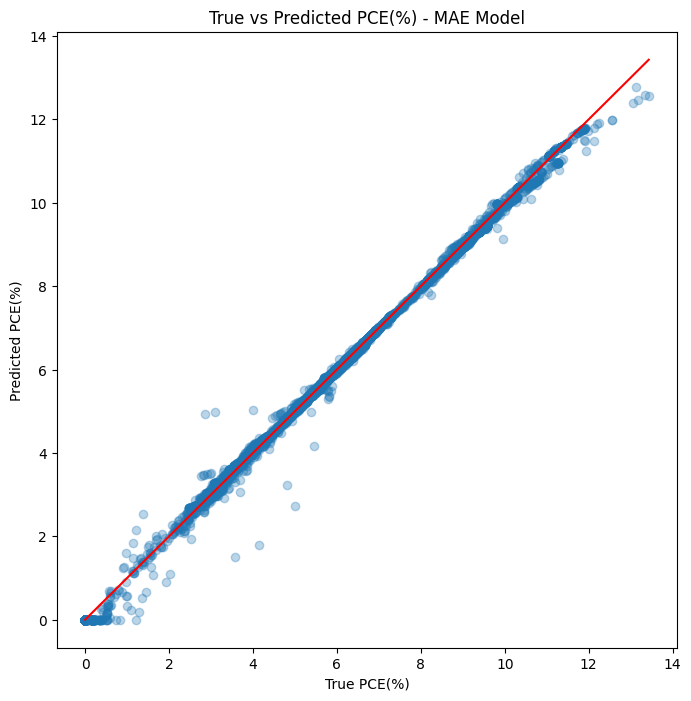

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


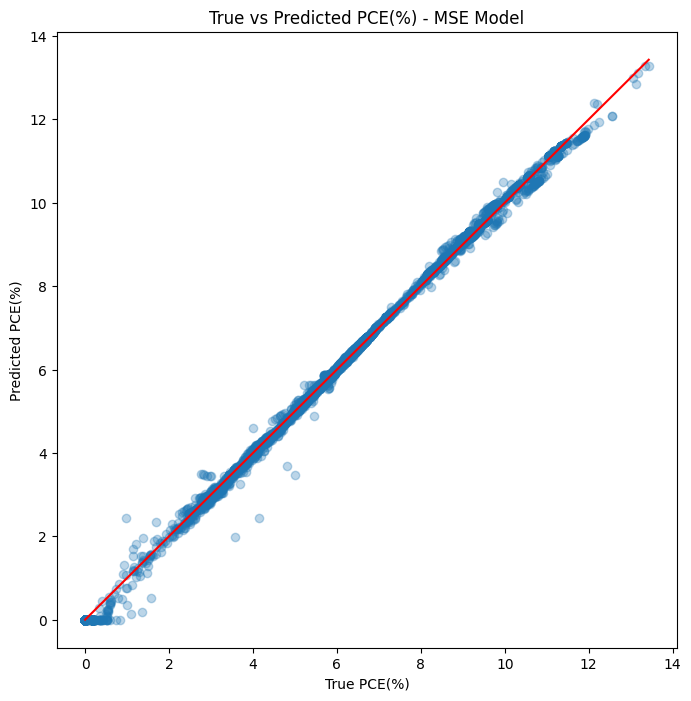

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


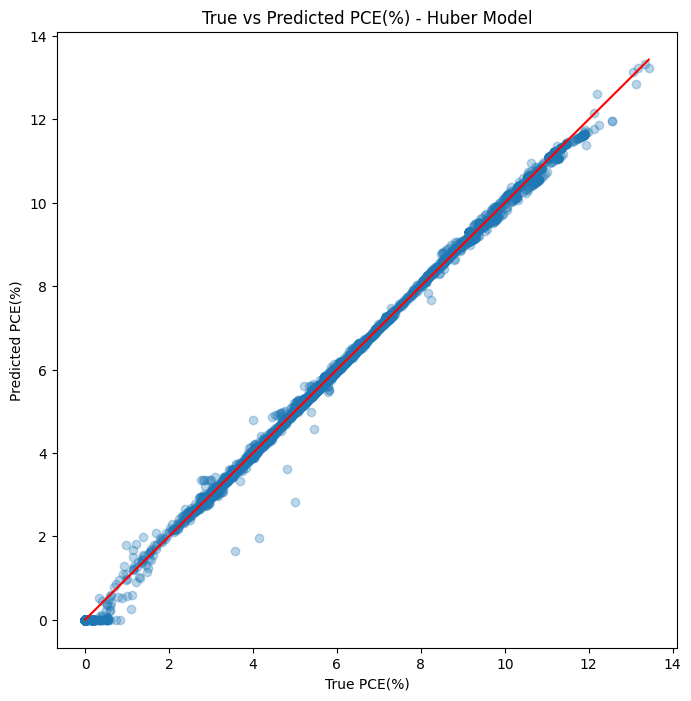

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


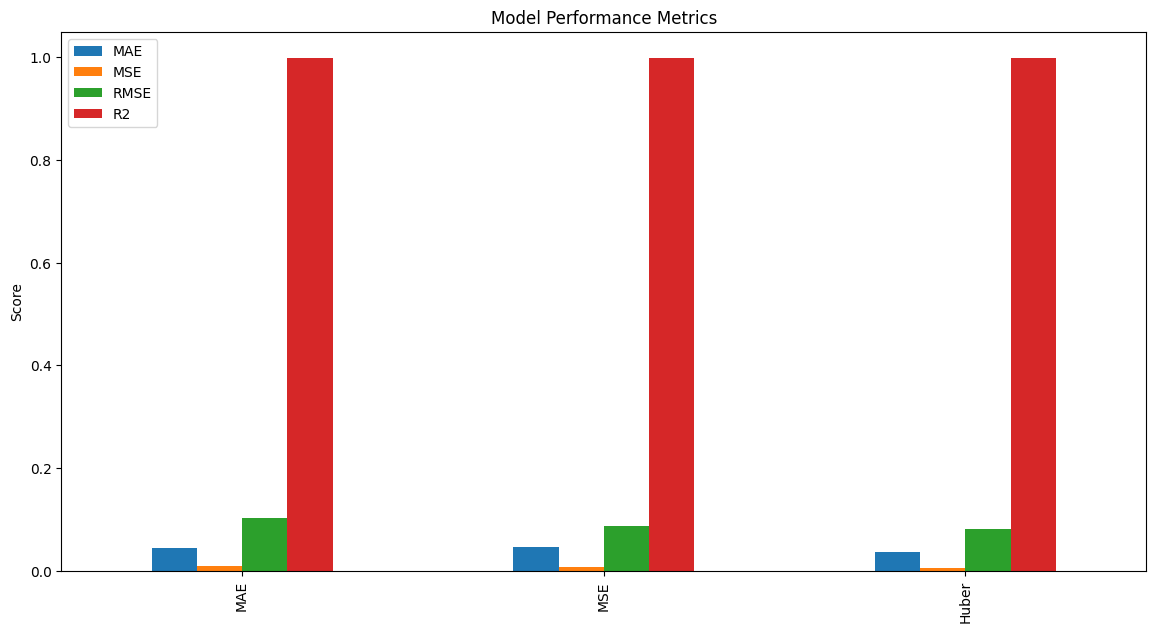

In [10]:
# Plot predictions
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('True PCE(%)')
    plt.ylabel('Predicted PCE(%)')
    plt.title(title)
    plt.show()

for name, model in models.items():
    plot_predictions(model, X_test_reshaped, y_test, f'True vs Predicted PCE(%) - {name} Model')

# Plot performance metrics
def plot_metrics(models, X_test, y_test):
    metrics = {'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}
    model_names = []
    for name, model in models.items():
        y_pred = model.predict(X_test)
        metrics['MAE'].append(mean_absolute_error(y_test, y_pred))
        metrics['MSE'].append(mean_squared_error(y_test, y_pred))
        metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        metrics['R2'].append(r2_score(y_test, y_pred))
        model_names.append(name)
    
    metrics_df = pd.DataFrame(metrics, index=model_names)
    metrics_df.plot(kind='bar', figsize=(14, 7))
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()

plot_metrics(models, X_test_reshaped, y_test)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


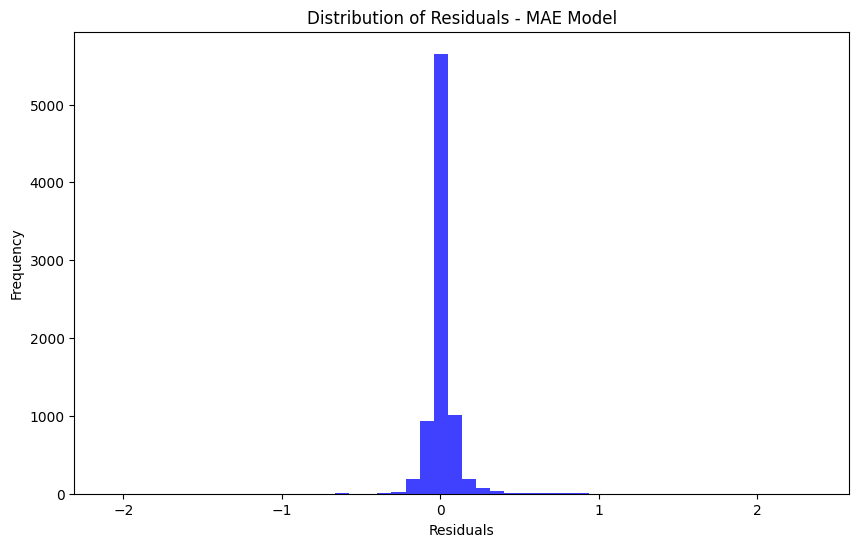

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


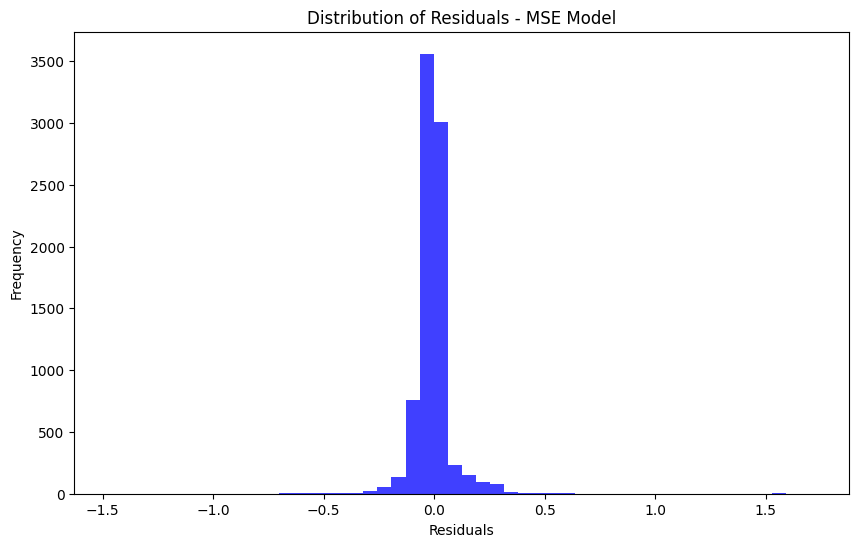

256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


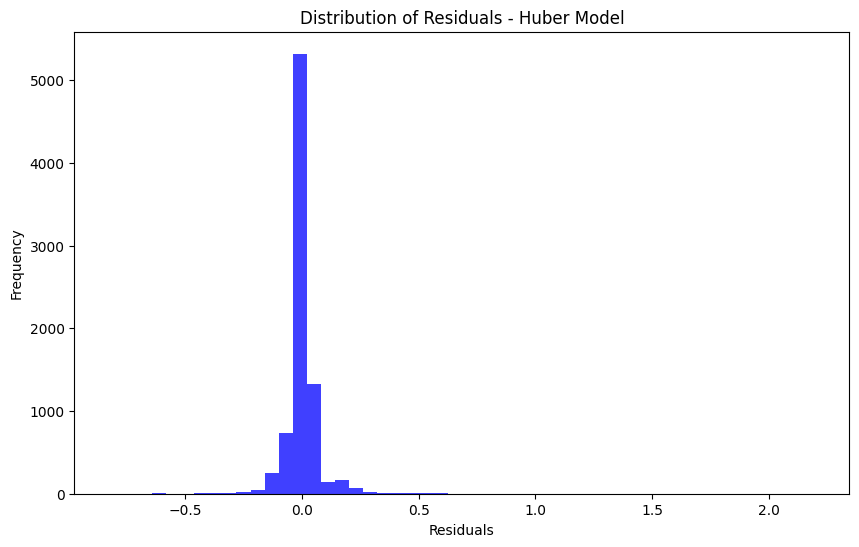

In [11]:
# Plot the distribution of differences between the predicted and true values
def plot_residuals(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, alpha=0.75, color='blue')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Plot residuals for each model
for name, model in models.items():
    plot_residuals(model, X_test_reshaped, y_test, f'Distribution of Residuals - {name} Model')
